# American Contigent Claims

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
#from sklearn.neighbors import KernelDensity

**Functions and model set-ups**

In [1]:
# valuation function
def valuation(S0, mu, r, sigma, T, N_dt, K):
    # calculate step size
    dt = T/N_dt
    # calculate the up move factor
    u = np.exp(sigma*np.sqrt(dt))
    # calculate the up move probability q
    q = (np.exp(r*dt) - 1/u) / (u - 1/u)

    # construct the price_tree for underlying stock S
    price_tree = np.zeros((N_dt+1,N_dt+1))
    price_tree[:] = np.nan
    price_tree[0,0] = S0
    for ii in range(1, N_dt+1):
        price_tree[0:ii, ii] = price_tree[0:ii, (ii-1)] * u
        price_tree[ii, ii] = price_tree[(ii-1), (ii-1)] / u

    # constructct the option_tree
    option_value_tree = np.zeros((N_dt+1,N_dt+1))
    option_value_tree[:] = np.nan
    option_value_tree[:,-1] = np.maximum(0, K - price_tree[:,-1])

    # constructuct the exercise_tree: 1 = early exercised
    exercise_tree = np.zeros((N_dt+1,N_dt+1))
    exercise_tree[:] = np.nan
    exercise_tree[:,-1] = (K >= price_tree[:,-1])

    # calculate the option price backward
    for i in range(N_dt):
        option_value_up = option_value_tree[0:N_dt-i, N_dt-i]
        option_value_down = option_value_tree[1:N_dt+1-i, N_dt-i]

        option_value_hold = np.exp(-r*dt)*(q*option_value_up + (1-q)*option_value_down)
        option_value_intrinsic = K - price_tree[:-i-1,N_dt-i-1]

        exercise_tree[:-i-1,N_dt-i-1] = option_value_hold < option_value_intrinsic
        option_value_tree[:-i-1,N_dt-i-1] = np.maximum(option_value_hold, option_value_intrinsic)

    # print(option_value_tree[0,0])
    # print(exercise_tree)
    # print(option_value_tree)

    #print(np.multiply(exercise_tree, option_value_tree))

    # calculate the exercise_boundary for each step
    # exercise boundary = the largest St that can early exercise @ time t
    temp = np.multiply(exercise_tree, price_tree)
    exercise_boundary = np.zeros(N_dt+1)
    for i in range(N_dt + 1):
        exercise_boundary[i] = np.nanmax(temp[:,i])
    # replace 0 by nan: means it is not optimal to early exercises
    #exercise_boundary[exercise_boundary == 0] = np.nan
    print(exercise_tree[:, -1])
    return price_tree, option_value_tree, option_value_tree[0,0], exercise_boundary

def plot_exercise_boundary(S0, mu, rs, sigmas, T, N_dt, K):
    plt.figure()
    plt.ylim((4,10))
    plt.ylabel("Stock Price $S_t$")
    plt.xlabel("t")
    plt.title("Exercise Boundary")
    for r in rs:
        for sigma in sigmas:
            exercise_boundary = valuation(10, 0.05, r, sigma, 1, 5000, 10)[-1]
            plt.plot(np.arange(0,1+1/5000,step=1/5000),exercise_boundary, label="r={}, $\sigma$={}".format(r,sigma))
    plt.legend()
    plt.savefig("exercise boundary ({},{}).png".format(r,sigma))

# 1. Exercising Boundaries

[0. 0. 0. ... 1. 1. 1.]
0.7513151803541919


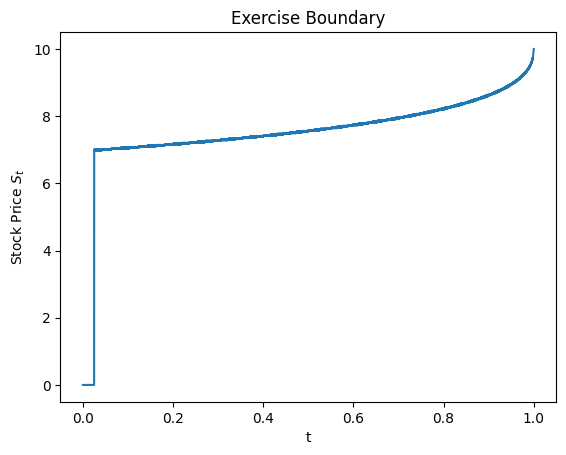

In [4]:
# Plot the exercise boundary as a function of t
price_tree, option_tree, price, exercise_boundary = valuation(10, 0.05, 0.01, 0.2, 1, 5000, 10)
print(price)
plt.figure()
plt.plot(np.arange(0,1+1/5000,step=1/5000),exercise_boundary)

plt.ylabel("Stock Price $S_t$")
plt.xlabel("t")
plt.title("Exercise Boundary")
plt.savefig("exercise boundary.png")


In [4]:
# hedging strategy (omitting value at maturity)
def plot_hedging_strategy(S0, mu, r, sigma, T, N_dt, K, ts):
    price_tree, option_value_tree = valuation(S0,mu,r,sigma,T,N_dt,K)[:2]

    Vs = []
    Ss = []
    alphas = []
    betas = []

    for t in ts:
        n = int(t*N_dt)

        if (t == T):
            alpha = (option_value_tree[:-1,-1] > 0)*-1
        else:
            Pu = option_value_tree[:-1,n+1]
            Pd = option_value_tree[1:,n+1]
            Su = price_tree[:-1,n+1]
            Sd = price_tree[1:,n+1]
            alpha = (Pu - Pd) / (Su - Sd)

        P0 = option_value_tree[:-1,n]
        S0 = price_tree[:-1,n]
        
        beta = P0 - alpha * S0
        V0 = alpha * S0 + beta * 1

        alphas.append(alpha)
        betas.append(beta)
        Ss.append(S0)
        Vs.append(V0)


    plt.figure()
    plt.xlim(0,20)
    plt.xlabel("Stock Price $S_t$")
    plt.title("Alpha vs Stock Price (r = {}, $\sigma$ = {})".format(r,sigma))
    for i in range(len(alphas)):
        if (i == 0):
            plt.plot(Ss[i],alphas[i], label="t = {}".format(ts[i]), marker="o")
        else:
            plt.plot(Ss[i],alphas[i], label="t = {}".format(ts[i]))
    plt.legend()
    plt.savefig("alpha ({},{}).png".format(r,sigma))

    plt.figure()
    plt.xlim(0,20)
    plt.xlabel("Stock Price $S_t$")
    plt.title("Beta vs Stock Price (r = {}, $\sigma$ = {})".format(r,sigma))
    for i in range(len(Vs)):
        if (i == 0):
            plt.plot(Ss[i],betas[i], label="t = {}".format(ts[i]), marker="o")
        else:
            plt.plot(Ss[i],betas[i], label="t = {}".format(ts[i]))
    plt.legend()
    plt.savefig("beta ({},{}).png".format(r,sigma))    

    plt.figure()
    plt.xlim(0,20)
    plt.xlabel("Stock Price $S_t$")
    plt.title("Portfolio vs Stock Price (r = {}, $\sigma$ = {})".format(r,sigma))
    for i in range(len(Vs)):
        if (i == 0):
            plt.plot(Ss[i],Vs[i], label="t = {}".format(ts[i]), marker="o")
        else:
            plt.plot(Ss[i],Vs[i], label="t = {}".format(ts[i]))
    plt.legend()
    plt.savefig("portfolio ({},{}).png".format(r,sigma))

    

# 2. Delta Hedging

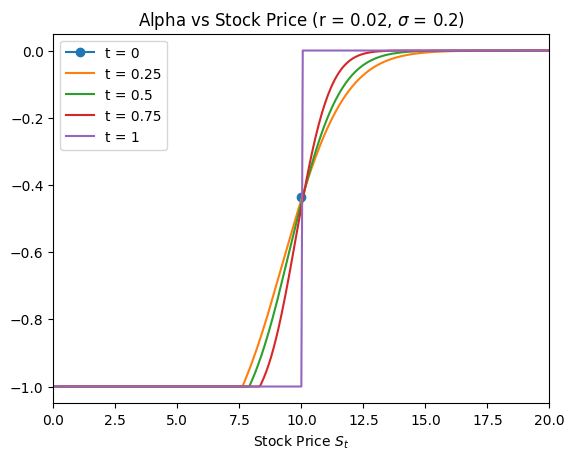

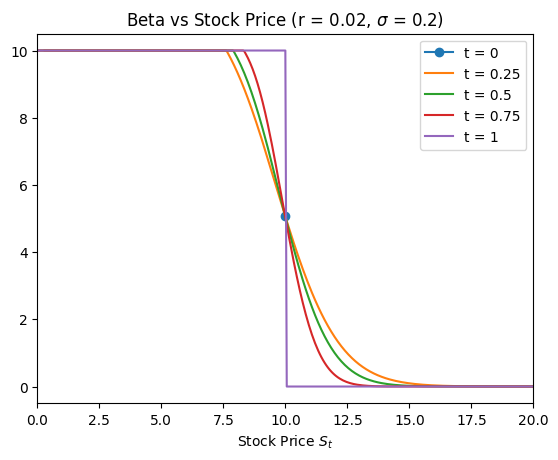

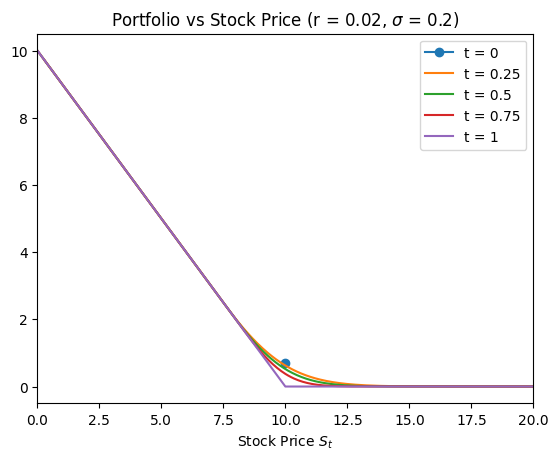

In [8]:
ts = [0,0.25,0.5,0.75,1]
rs = [0.02, 0.04, 0.10]
sigmas = [0.1,0.2,0.3]

plot_hedging_strategy(10,0.05,0.02,0.2,1,5000,10,ts)

In [6]:
# construct european put trees

'for r in rs:\n    for sigma in sigmas:\n        plot_hedging_strategy(10,0.05,r,sigma,1,5000,10,ts)'

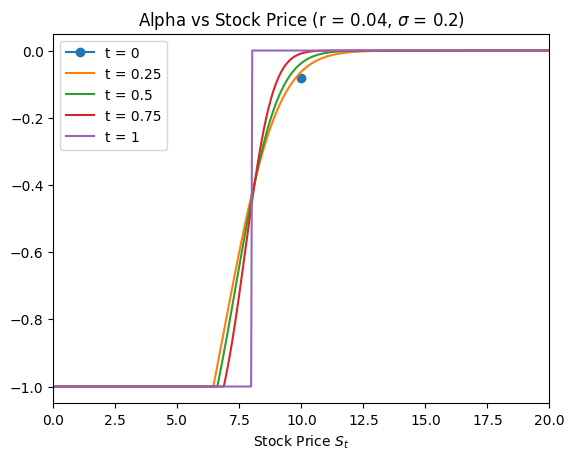

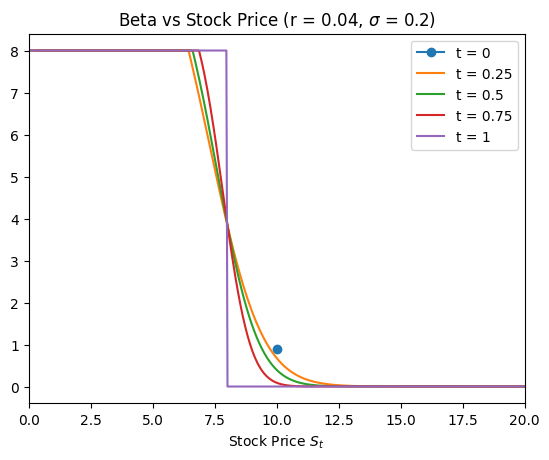

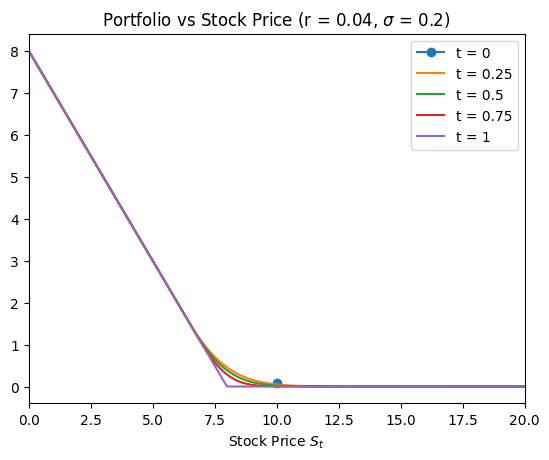

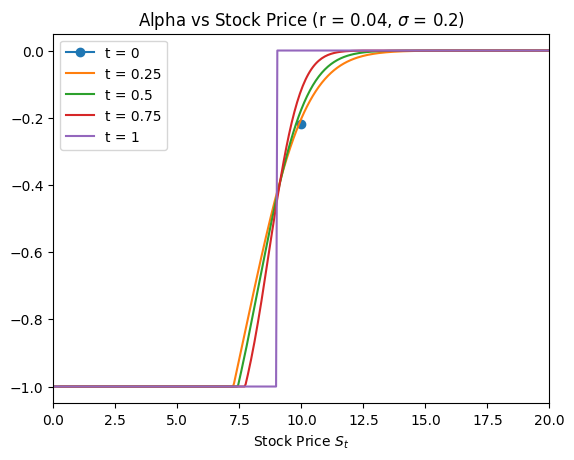

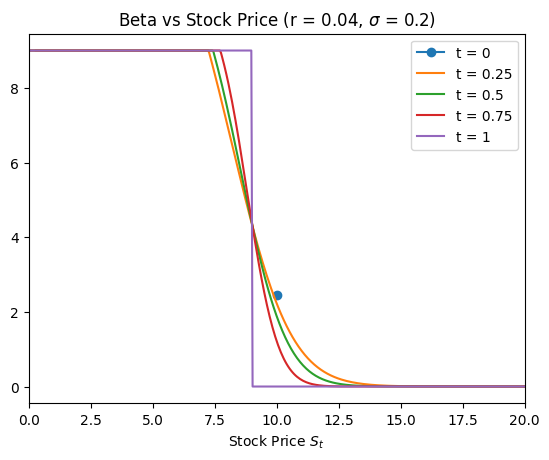

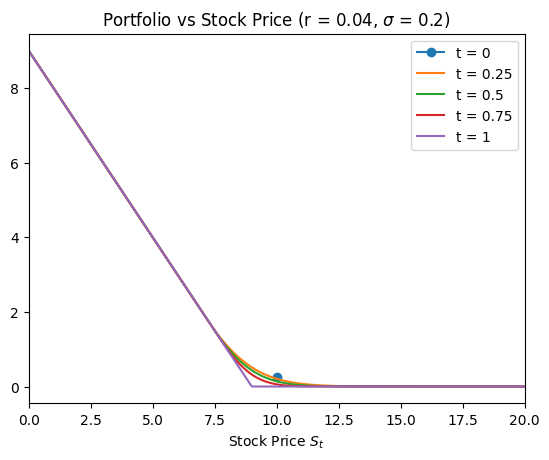

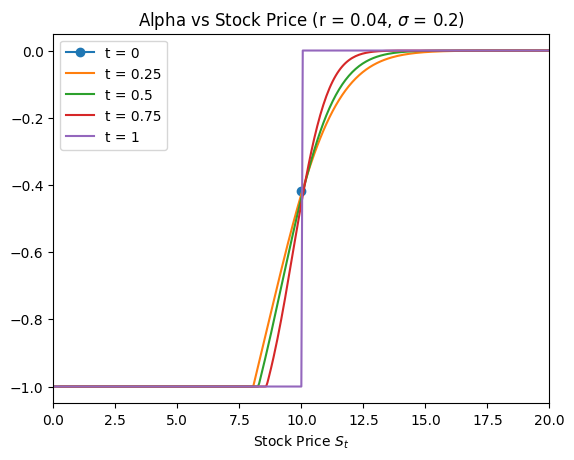

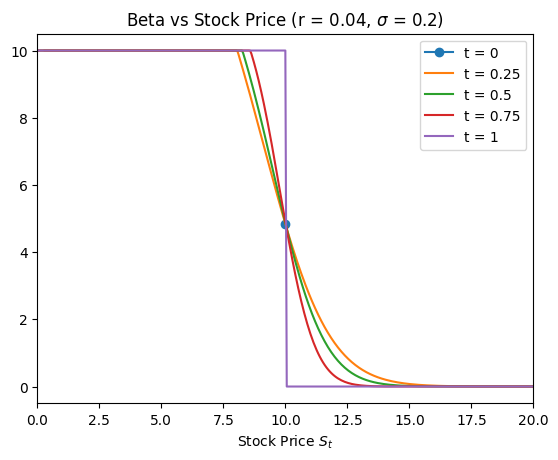

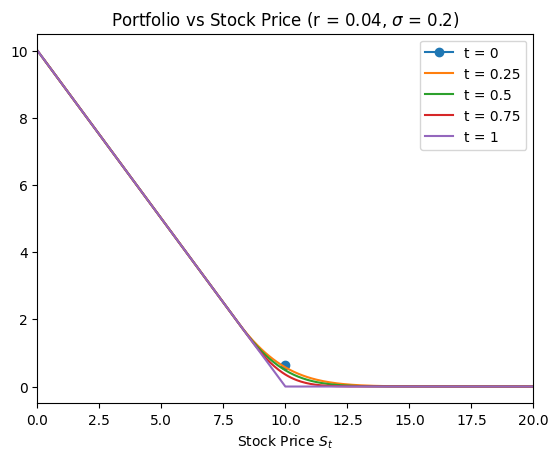

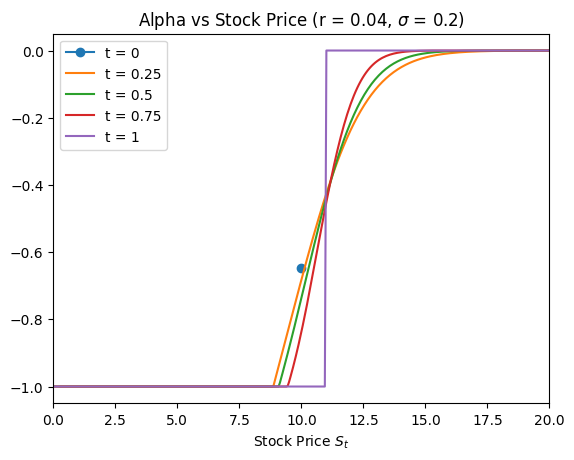

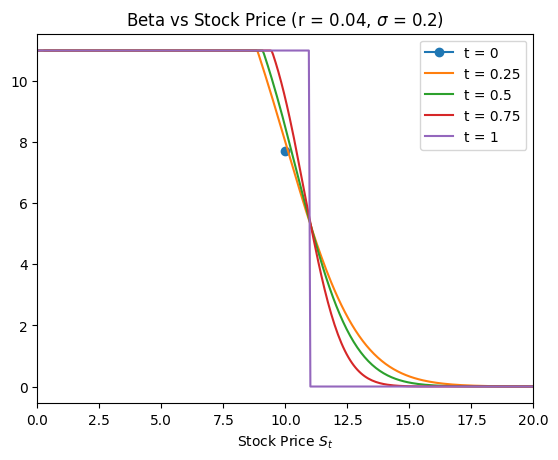

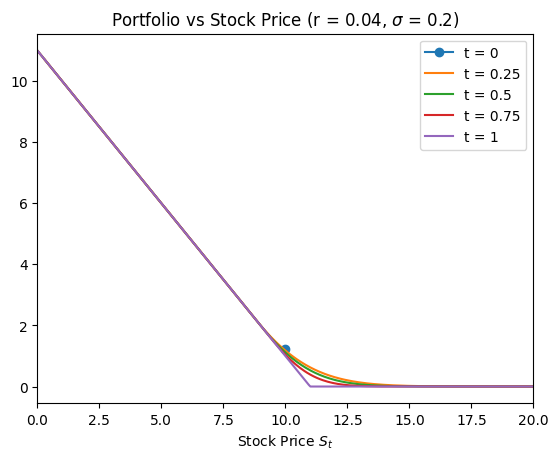

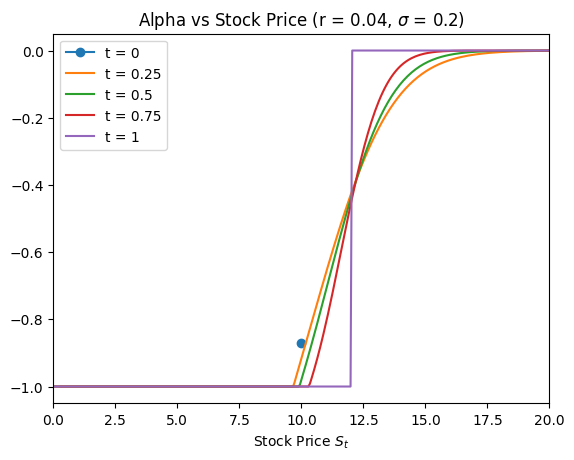

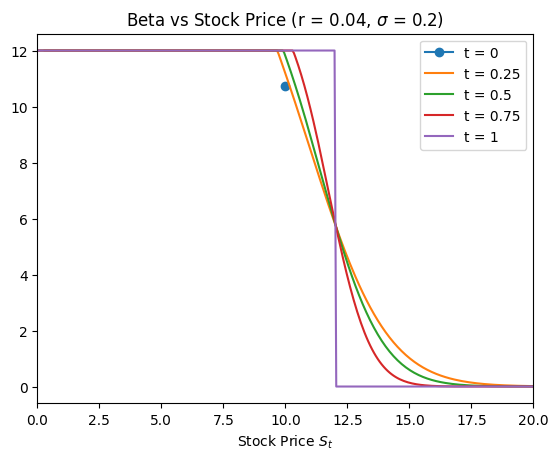

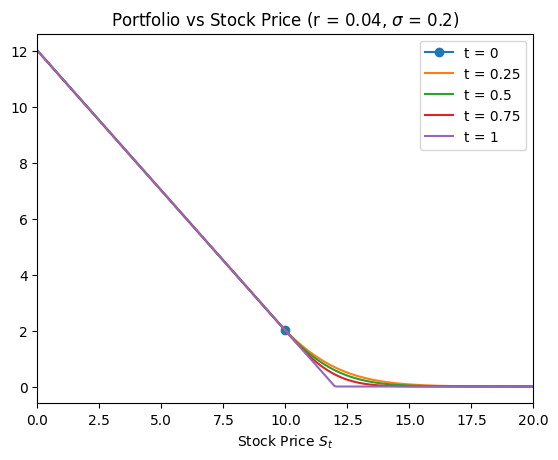

In [11]:
ts = [0,0.25,0.5,0.75,1]
rs = [0.02, 0.04, 0.10]
sigmas = [0.1,0.2,0.3]
k = [8,9,10,11,12]
       
plot_exercise_boundary(10,0.05,[0.02],[0.1,0.2,0.3],1,5000,10)
plot_exercise_boundary(10,0.05,[0.04],[0.1,0.2,0.3],1,5000,10)
plot_exercise_boundary(10,0.05,[0.10],[0.1,0.2,0.3],1,5000,10)

plot_exercise_boundary(10,0.05,[0.02,0.04,0.1],[0.1],1,5000,10)
plot_exercise_boundary(10,0.05,[0.02,0.04,0.1],[0.2],1,5000,10)
plot_exercise_boundary(10,0.05,[0.02,0.04,0.1],[0.3],1,5000,10)


for r in rs:
    for sigma in sigmas:
        plot_hedging_strategy(10,0.05,r,sigma,1,5000,10,ts)


# 3. Stochastic Simulations and KDE Estimation

In [31]:
def sim(S0, mu, r, sigma, T, N_dt, N_paths, K, american_put_price, exercies_boundary):
    dt = T/N_dt
    p = 0.5*(1+((mu-r)-0.5*sigma**2)*np.sqrt(dt)/sigma)

    S = np.zeros((N_paths, N_dt+1))
    S[:,0] = S0
    early_exercises_indicator = np.zeros((N_paths, N_dt+1))

    #american_put_price, exercise_boundary = valuation(S0, mu, r, sigma, T, N_dt, K)

    for n in range(N_dt):
        U = np.random.rand(N_paths)
        x = 1*(U<p) - 1*(U>=p)
        
        S[:,n+1] = S[:,n] * np.exp(r*dt + sigma * np.sqrt(dt)*x)

        # if the current price is below the exercise boudary, should early exercise
        early_exercises_indicator[:,n+1] = S[:,n+1] < exercise_boundary[n+1]
    qt1 = np.quantile(S, [0.1, 0.5, 0.9], axis = 0)
    plt.plot(np.arange(0,1+1/5000,step=1/5000),S.T, linewidth=0.1    )
    plt.plot(np.arange(0,1+1/5000,step=1/5000), qt1[0,:] , linewidth= 1, color="red", label = "10th Quantile")
    plt.plot(np.arange(0,1+1/5000,step=1/5000), qt1[1,:] , linewidth= 1, color="blue", label = "50th Quantile")
    plt.plot(np.arange(0,1+1/5000,step=1/5000), qt1[2,:] , linewidth= 1, color="green", label = "90th Quantile")
    plt.plot(np.arange(0,1+1/5000,step=1/5000),exercise_boundary, linewidth= 1, color="black", label = 'Exercise Boundary')
    plt.xlabel(r'$t$')
    plt.ylabel("Stock Price($)")
    plt.legend(loc="lower left")
    plt.show()
    # calculate PV(payoff) for each simulation
    payoff = np.zeros(N_paths)
    exercise_time = np.zeros(N_paths)
    for n in range(N_paths):
        if early_exercises_indicator[n,-1] == 0:
            # case 1: didn't early exercise
            if K < S[n,-1]:
                # case 1.a: K < S_T -> didn't exercise ? 
                payoff[n] = 0
                exercise_time[n] = np.nan 
            else:
                # case 1.b: K > S_T -> exercised ?
                payoff[n] = np.maximum(0, K - S[n,-1]) * np.exp(-r*T)
                exercise_time[n] = T
        else:
            # case 2: early exercised
            # find the step when early exercised
            step = np.where(early_exercises_indicator[n,:] == 1)[0][0]
            payoff[n] = np.maximum(0, K - S[n,-1]) * np.exp(-r*step*dt)
            exercise_time[n] = step*dt
    # subtract 
    pv_profit = payoff - american_put_price

    return S,pv_profit, exercise_time 

def plot_kde(data, bdwidth,a,b, title):

    kde = gaussian_kde(data)
    x = np.linspace(a,b, 100)
    kde_pdf = kde.evaluate(x)
    plt.hist(data, weights=np.zeros_like(data) + 1. / data.size)
    plt.plot(x,kde_pdf)
    plt.title(title, fontsize=10)
    '''
    X_sample = []
    for x in data:
        X_sample.append([x])

    kde = KernelDensity(kernel="gaussian", bandwidth=bdwidth).fit(X_sample)
    X_plot = np.linspace(a,b, 100)[:, np.newaxis]
    log_dens = kde.score_samples(X_plot)
    plt.hist(data, weights=np.zeros_like(data) + 1. / data.size)
    plt.plot(np.linspace(a,b, 100),np.exp(log_dens))
    plt.title(title, fontsize=10)
    '''


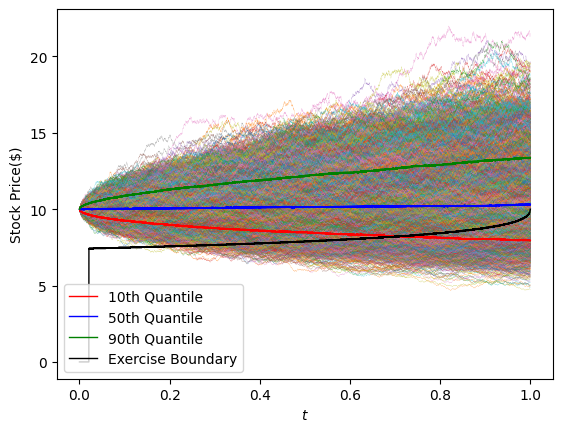

(array([[10.        , 10.02836442, 10.0568093 , ...,  8.09014026,
          8.06732249,  8.09020498],
        [10.        , 10.02836442, 10.00008   , ..., 10.98044758,
         11.01159298, 11.04282673],
        [10.        ,  9.97179558,  9.94367071, ...,  8.85653617,
          8.88165722,  8.90684953],
        ...,
        [10.        , 10.02836442, 10.00008   , ...,  8.90677828,
          8.88165722,  8.85660702],
        [10.        , 10.02836442, 10.00008   , ...,  8.80657747,
          8.78173903,  8.75697064],
        [10.        , 10.02836442, 10.0568093 , ..., 10.43540665,
         10.46500608, 10.43549014]]),
 array([1.87651421, 0.        , 1.07718576, ..., 1.12238528, 1.22086476,
        0.        ]),
 array([0.879 ,    nan, 0.7356, ..., 0.9272, 0.8996,    nan]))

In [32]:
exercise_boundary = valuation(10, 0.05, 0.02, 0.2, 1, 5000, 10)[-1]
american_put_price = 0
sim(10,0.05,0.02,0.2,1,5000,10000,10, american_put_price, exercise_boundary)

-0.134417316833635 0.7859615816670411


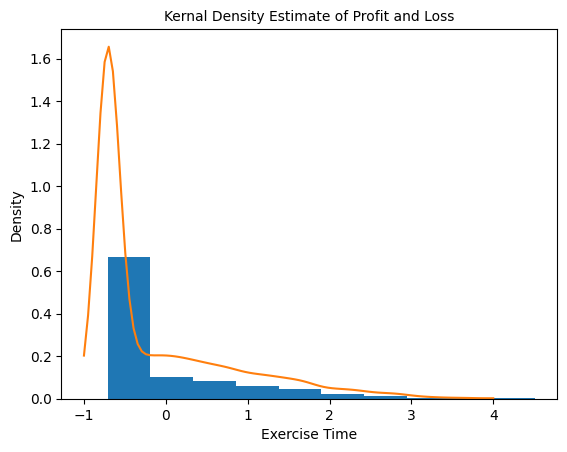

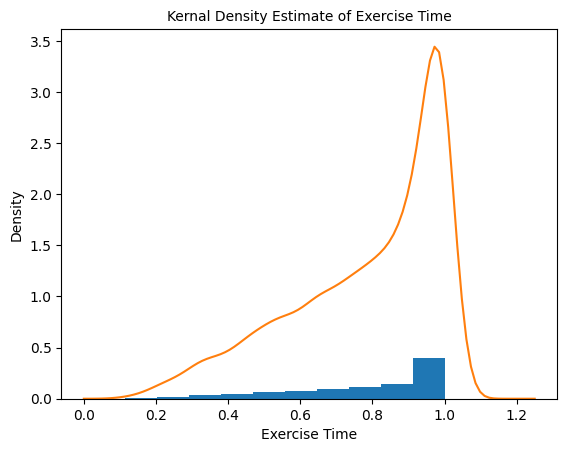

In [13]:
'''
Simulate 10,000 sample paths of the asset and obtain a kernel density estimate of 
    (i) profit and loss you will receive, and 
    (ii) the distribution of the time at which you exercise the option. 
Explore how the various model parameters effect these distributions.
'''

from numpy import average


price_tree, option_tree, american_put_price, exercies_boundary = valuation(10,0.05,0.02,0.2,1,5000,10)
sim_S, result_profit, result_exercise_time = sim(10,0.05,0.02,0.2,1,5000,10000,10, american_put_price, exercies_boundary)
plt.figure()
plt.xlabel("Exercise Time")
plt.ylabel("Density")
plot_kde(result_profit, 0.15, -1, 4, "Kernal Density Estimate of Profit and Loss")
plt.savefig('3(b)i - KDE of pnl.png')
result_exercise_time_exclude_nan = result_exercise_time[~np.isnan(result_exercise_time)]
plt.figure()
plt.xlabel("Exercise Time")
plt.ylabel("Density")
plot_kde(result_exercise_time_exclude_nan, 0.05, 0, 1.25, "Kernal Density Estimate of Exercise Time")
plt.savefig('3(b)i - KDE of exercise time.png')
print(average(result_profit), average(result_exercise_time_exclude_nan))


-0.5095804155965973 0.9562545734524177
-0.3231738229562641 0.8783111277072442
-0.13292850776936274 0.7777351809436556
0.03823750482527025 0.6926655422715627
0.27546535012209444 0.6102878196094222


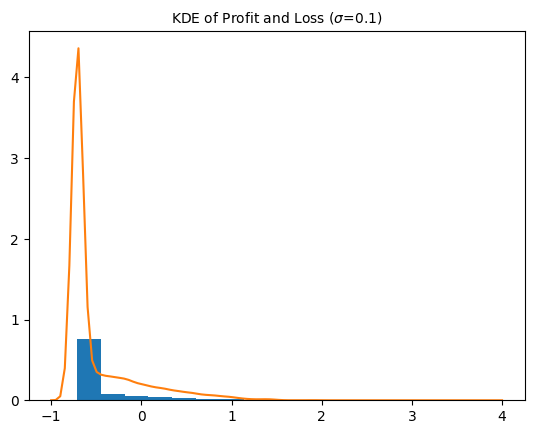

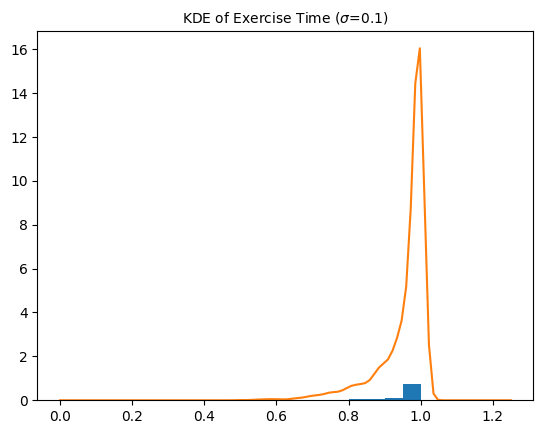

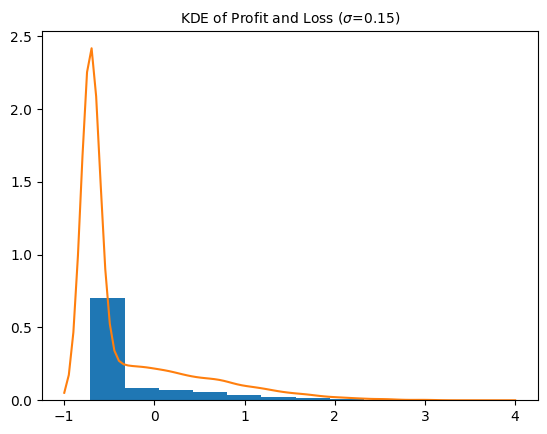

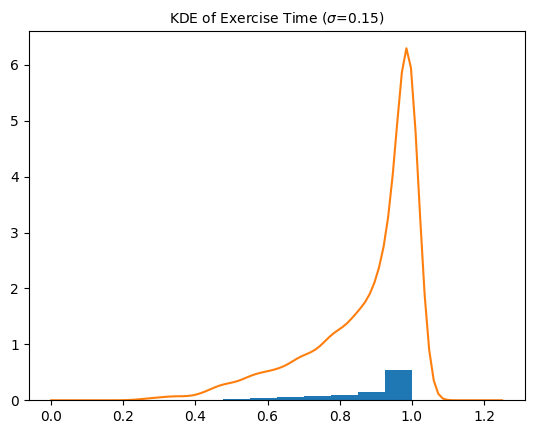

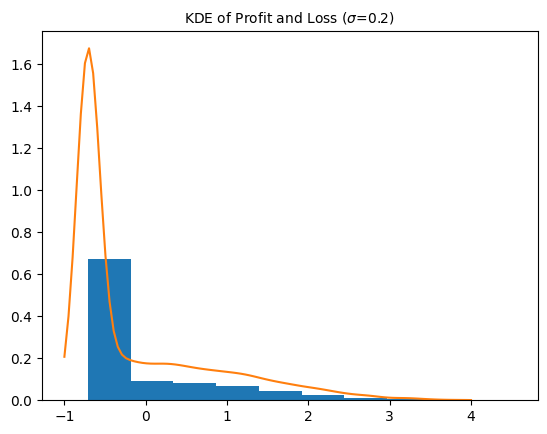

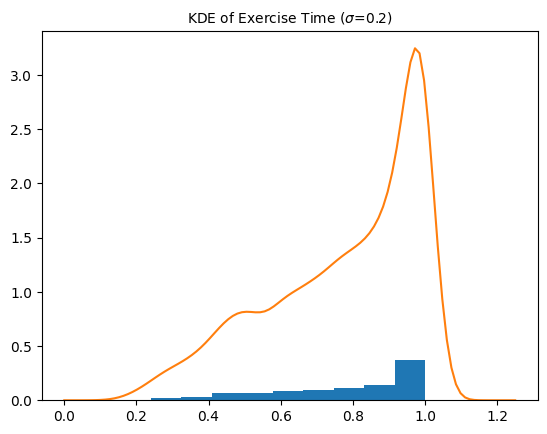

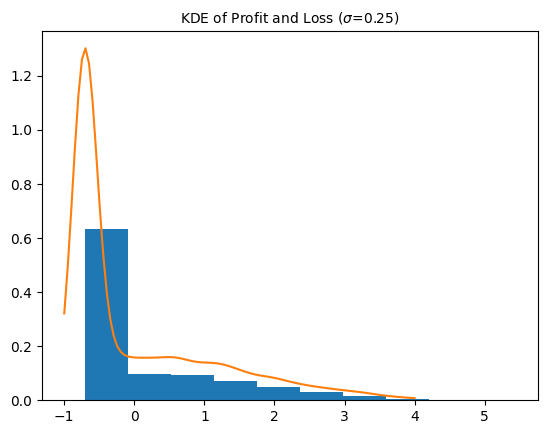

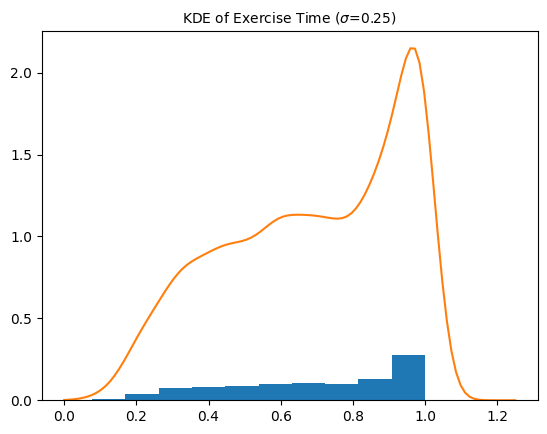

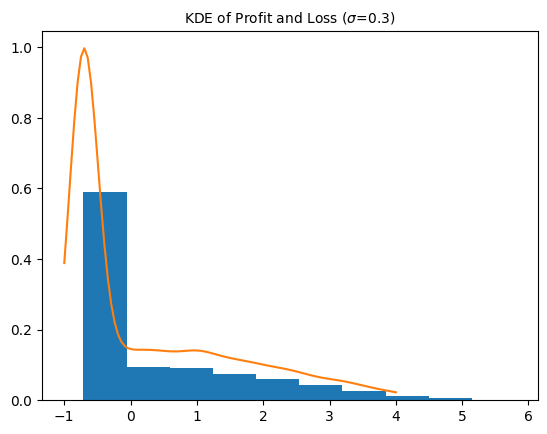

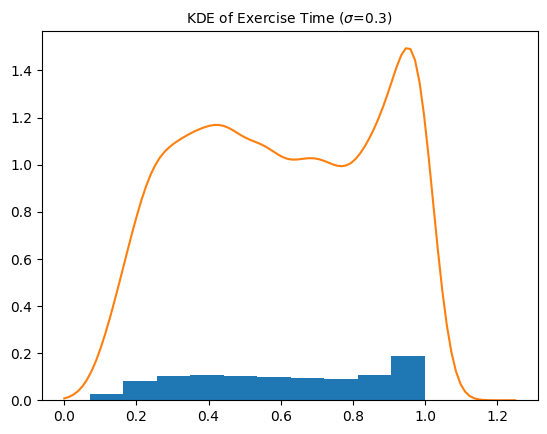

In [14]:
'''
Suppose that the realized volatility is sigma = 10%; 15%; 20%; 25%; 30%, but you were able
to purchase the option with a volatility of sigma = 20% and you use the sigma = 20% exercise
boundary in your trading strategy. Explore how the distributions of profit and loss and
exercise time vary in this case.
'''

sigmas = [0.10, 0.15,0.20,0.25,0.30]
price_tree, option_tree,american_put_price, exercies_boundary = valuation(10,0.05,0.02,0.2,1,5000,10)


#plt.figure()
#plt.subplots(5,2,constrained_layout=True)

for i in range(len(sigmas)):
    sim_S, result_profit, result_exercise_time = sim(10,0.05,0.02,sigmas[i],1,5000,10000,10, american_put_price, exercies_boundary)
    plt.figure()
    plot_kde(result_profit, 0.15, -1, 4, "KDE of Profit and Loss ($\sigma$={})".format(sigmas[i]))
    plt.savefig('3(b)ii - KDE of pnl sigma{}.png'.format(sigmas[i]))
    plt.figure()
    result_exercise_time_exclude_nan = result_exercise_time[~np.isnan(result_exercise_time)]
    plot_kde(result_exercise_time_exclude_nan, 0.05, 0, 1.25, "KDE of Exercise Time ($\sigma$={})".format(sigmas[i]))
    plt.savefig('3(b)ii - KDE of exercise time sigma{}.png'.format(sigmas[i]))
    print(average(result_profit), average(result_exercise_time_exclude_nan))
